In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
import numpy as np
import h5py
import geopandas as gpd
import matplotlib.pyplot as plt
import os.path
import torch

import numpy as np 
from torchvision import transforms
from torch.utils.data import DataLoader 
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch

from CSIencoder import Encoder
encoded_dim  = 32
lr= 0.0002
batch_size = 32
weight_decay = 0.0001
num_epochs = 20

Kp = 16  # number of positive samples
Kn = 64  # number of negative samples
tau  = 1.5  # temperature for the Contrastive loss
beta = 1
A=56  # number of antennas
M=5

skip_train = False
skip_DistG = True


In [8]:
Ns  = np.array([512, 512, 512, 512, 512, 512, 512, 512, 883])
NN  = np.sum(Ns) 
N_trained = int(0.9*NN)  # 90% for train
N_tested  = NN-N_trained

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.cuda.manual_seed(seed)
     np.random.seed(seed)
setup_seed(2022) 
RandIndexs = torch.randperm(NN).numpy()

SNRs = np.load("SNRs.npy")
SNRs = SNRs[RandIndexs,::]

XYs  = np.load("XYs.npy")
XYs  = XYs[RandIndexs,::]

DistMatrix_all = np.load("DistMatrix_16bits.npy")
DistMatrix_all = DistMatrix_all[RandIndexs,:]
DistMatrix_all = DistMatrix_all[:,RandIndexs]
CSIs = np.load("CSIs_used.npy")
CSIs = CSIs[RandIndexs,::]

Train_CSIs  = CSIs[0:N_trained,::]

print("SNRs is of shape {}".format(SNRs.shape))
print("XYs  is of shape {}".format(XYs.shape ))
print("CSIs is of shape {}".format(CSIs.shape))

DistMatrix = DistMatrix_all[0:N_trained,0:N_trained]

SNRs is of shape (4979, 56, 5)
XYs  is of shape (4979, 3)
CSIs is of shape (4979, 56, 56)


In [9]:
encoder = Encoder(encoded_space_dim=encoded_dim)
params_to_optimize = [{'params': encoder.parameters()}]
optim  = torch.optim.Adam(params_to_optimize, lr=lr,weight_decay=weight_decay)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
encoder.to(device)

Selected device: cuda


Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Tanh()
    (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Tanh()
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): Tanh()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=20000, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=32, bias=True)
  )
)

In [10]:

train_dataset = torch.Tensor(CSIs[0:N_trained])
valid_dataset = torch.Tensor(CSIs[N_trained: ])

train_dataset = torch.unsqueeze(train_dataset, 1).to(device)
valid_dataset = torch.unsqueeze(valid_dataset, 1).to(device)

train_transform = transforms.Compose([transforms.ToTensor(),])
valid_transform = transforms.Compose([transforms.ToTensor(),])

train_dataset.transform = train_transform
valid_dataset.transform = valid_transform

n_train_samples = len(train_dataset)
n_valid_samples = len(valid_dataset)

In [11]:
diz_loss = {'train_loss':[]}
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)

DistMatrix_Sorted = np.sort(DistMatrix)
index_sorts = []
for Imagindex in range(N_trained):
   index_sort = np.argsort(DistMatrix[Imagindex,:])
   index_sorts.append(index_sort)

ths_kp    = DistMatrix_Sorted[:,Kp+1]
th_kp_max = np.max(ths_kp)
if th_kp_max < 25:
   th_kp_max = 25
th_kp_indexs = DistMatrix_Sorted <= th_kp_max
num_ns = np.sum(th_kp_indexs,axis = 1)

image_p = torch.zeros(batch_size*Kp,1,A,A).to(device)
image_n = torch.zeros(batch_size*Kn,1,A,A).to(device)

if skip_train  == False:
   for epoch in range(num_epochs):
      train_loader = DataLoader(range(len(train_dataset)), batch_size=batch_size,shuffle=True)
      encoder.train()
      train_loss = []
      for image_Indexs in train_loader:
         image_a = train_dataset[image_Indexs,::]
         batch_pi = 0
         for Imagindex in image_Indexs:
            index_sort    = index_sorts[Imagindex]
            dist_v_sorted = DistMatrix_Sorted[Imagindex,:]
            for i in range(Kp):
               image_p[batch_pi*Kp+i,0,::] = train_dataset[index_sort[1+i],::]
            k_in = num_ns[Imagindex] + 1
            index_n = torch.randperm(N_trained - 1 - k_in)
            for i in range(Kn):
               image_n[batch_pi*Kn+i,0,::] = train_dataset[index_sort[k_in + index_n[i]],::]
            batch_pi = batch_pi + 1
         image_batch = torch.cat((image_a,image_p,image_n),0)
         image_batch = image_batch.to(device)

         encoded   = encoder(image_batch)
         encoded_a = encoded[0:batch_size]
         encoded_p = encoded[batch_size:batch_size+batch_size*Kp]
         encoded_n = encoded[batch_size+batch_size*Kp: batch_size+batch_size*Kp + batch_size*Kn]
         # Evaluate loss
         loss = 0
         for bi in range(batch_size):
            z_i = encoded_a[bi,:]
            z_p = encoded_p[bi*Kp:(bi*Kp+Kp),::]
            z_n = encoded_n[bi*Kn:(bi*Kn+Kn),::]
            anchor_dot_p = torch.div(torch.matmul(z_p,z_i.T),tau)
            anchor_dot_n = torch.div(torch.matmul(z_n,z_i.T),tau)
            exp_p = torch.exp(anchor_dot_p)
            exp_n = torch.exp(anchor_dot_n)
            sum_a = exp_p.sum() + exp_n.sum()
            log_p = torch.log(torch.div(beta*exp_p,sum_a))
            loss = loss - log_p.sum()
         loss= loss.to(device)
         optim.zero_grad()
         loss.backward()
         optim.step()
         train_loss.append(loss.detach().cpu().numpy())
      scheduler.step()
      diz_loss['train_loss'].append(np.mean(train_loss))
      print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs,np.mean(train_loss)))
   torch.save(encoder,"CSIencoder10per.pkl")

C:\Users\Neil\AppData\Local\Temp/ipykernel_28336/3631841899.py:51: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2318.)
  anchor_dot_p = torch.div(torch.matmul(z_p,z_i.T),tau)



 EPOCH 1/20 	 train loss 1650.8468017578125

 EPOCH 2/20 	 train loss 1573.3173828125

 EPOCH 3/20 	 train loss 1563.0255126953125

 EPOCH 4/20 	 train loss 1538.6641845703125

 EPOCH 5/20 	 train loss 1531.1861572265625

 EPOCH 6/20 	 train loss 1519.2486572265625

 EPOCH 7/20 	 train loss 1516.466064453125

 EPOCH 8/20 	 train loss 1517.6375732421875

 EPOCH 9/20 	 train loss 1512.62939453125

 EPOCH 10/20 	 train loss 1505.7486572265625

 EPOCH 11/20 	 train loss 1503.303466796875

 EPOCH 12/20 	 train loss 1502.8814697265625

 EPOCH 13/20 	 train loss 1498.094970703125

 EPOCH 14/20 	 train loss 1499.324951171875

 EPOCH 15/20 	 train loss 1494.301513671875

 EPOCH 16/20 	 train loss 1490.448974609375

 EPOCH 17/20 	 train loss 1494.2518310546875

 EPOCH 18/20 	 train loss 1494.7313232421875

 EPOCH 19/20 	 train loss 1484.6785888671875

 EPOCH 20/20 	 train loss 1487.81982421875


In [12]:
encoder = Encoder(encoded_space_dim = encoded_dim)
encoder = torch.load("CSIencoder10per.pkl") 
device  = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
encoder.to(device)

from tqdm.notebook import tqdm
import pandas as pd 
encoded_samples = []
dataset = torch.Tensor(CSIs)
dataset = torch.unsqueeze(dataset, 1)
for sample in tqdm(dataset):
    img = sample.unsqueeze(0).to(device)
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)

Selected device: cuda


  0%|          | 0/4979 [00:00<?, ?it/s]

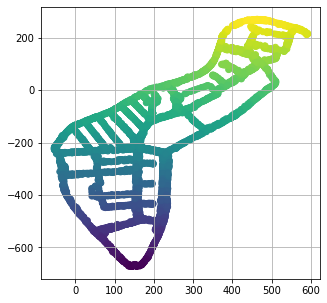

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/4481 [00:00<?, ?it/s]

In [13]:
from sklearn.manifold import TSNE
plt.figure(figsize=(5,5))
plt.scatter(XYs[:,0],XYs[:,1],c=XYs[:,1],cmap = 'viridis')
plt.grid()
plt.show()

encoded_tests = []
for sample in tqdm(valid_dataset):
    img = sample.unsqueeze(0).to(device)
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_tests.append(encoded_sample)
encoded_tests = pd.DataFrame(encoded_tests)

encoded_train = []
for sample in tqdm(train_dataset):
    img = sample.unsqueeze(0).to(device)
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_train.append(encoded_sample)
encoded_train = pd.DataFrame(encoded_train)

In [28]:
#KNN using learned CSI feature
XYs_train = XYs[0:N_trained,0:2]
XYs_tests = XYs[N_trained:, 0:2]
encoded_train_np = encoded_train.to_numpy()
encoded_tests_np = encoded_tests.to_numpy()
N_train = len(XYs_train)
N_tests = len(XYs_tests)
Distance_Matrix_enc   = np.zeros((N_tests,N_train))
if skip_train ==False:
    for i in range(N_tests):
        vi = encoded_tests_np[i,:]
        for j in range(N_train):
            vj = encoded_train_np[j,:]
            Distance_Matrix_enc[i,j]   = np.linalg.norm(vi-vj)
    np.save("Distance_Matrix_enc.npy",  Distance_Matrix_enc)

In [29]:
Distance_Matrix_enc   = np.load("Distance_Matrix_enc.npy")

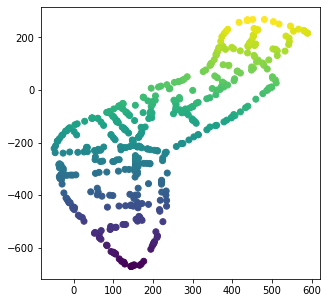

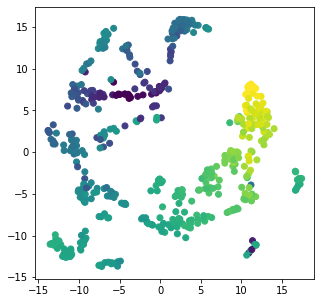

In [30]:
tsne = TSNE(n_components=2,perplexity = 50)
tsne_tests = tsne.fit_transform(encoded_tests)
x = XYs[N_trained:NN,0]
y = XYs[N_trained:NN,1]
plt.figure(figsize=(5,5))
plt.scatter(x,y,c = XYs_tests[:,1],cmap = 'viridis')
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(tsne_tests[:,0],tsne_tests[:,1],c=XYs_tests[:,1],cmap = 'viridis')
plt.show()

In [31]:
Knn = 4
SortIndexs_dis = np.argsort(Distance_Matrix_enc,   axis=1)
XYs_pred_sim = np.zeros((N_tests,2))
XYs_pred_dis = np.zeros((N_tests,2))
for i in range(N_tests):
    K_Neig_dis = XYs_train[SortIndexs_dis[i,0:Knn],:]
    Diss = Distance_Matrix_enc[i,SortIndexs_dis[i,0:Knn]]
    weights = 1/Diss
    weights = weights/np.sum(weights)
    XYs_pred_dis[i,0] = np.sum(weights*K_Neig_dis[:,0])
    XYs_pred_dis[i,1] = np.sum(weights*K_Neig_dis[:,1])

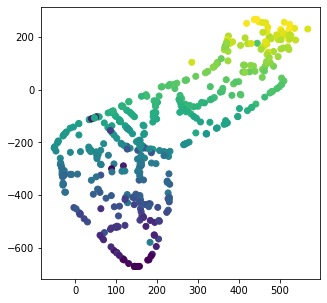

34.22048637717215


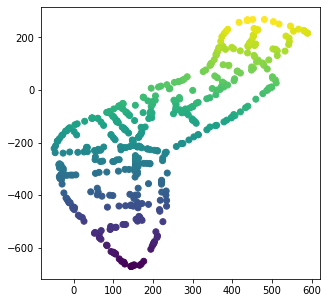

In [32]:
x = XYs_pred_dis[:,0], 
y = XYs_pred_dis[:,1], 

plt.figure(figsize=(5,5))
plt.scatter(x,y,c=XYs_tests[:,1],cmap = 'viridis')
plt.savefig("supcon.pdf", dpi = 400, bbox_inches = 'tight', pad_inches = 0)
plt.show()

Es = XYs_tests - XYs_pred_dis
Es_dis  = np.sqrt(Es[:,0]*Es[:,0] + Es[:,1]*Es[:,1])
MLE_dis = np.mean(Es_dis)
print(MLE_dis)
data_sorted_dis = np.sort(Es_dis)
p_dis = 1. * np.arange(len(Es_dis)) / (len(Es_dis) - 1)

x = XYs[N_trained:NN,0],
y = XYs[N_trained:NN,1], 
plt.figure(figsize=(5,5))
plt.scatter(x,y,c=XYs_tests[:,1],cmap = 'viridis')
plt.savefig("True.pdf", dpi = 400, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [19]:
CSIsComplex = np.zeros(CSIs.shape) + 1j*np.zeros(CSIs.shape)
for i in range(NN):
    #breakpoint()
    CSI = CSIs[i,::]
    CSI_r = np.triu(CSI, 1)
    CSI_i = np.tril(CSI,-1)
    CSI_i = np.transpose(CSI_i)
    CSI_d = np.diag(np.diag(CSI))
    CSI_o = CSI_r + 1j*CSI_i
    CSI_o = CSI_o + np.conj(CSI_o).T + CSI_d
    CSIsComplex[i,::] = CSI_o

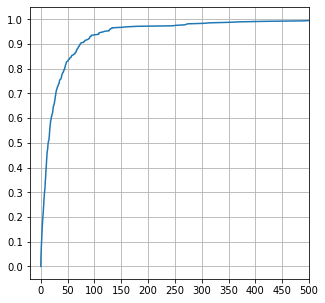

In [20]:
#===================================================================
plt.figure(figsize=(5,5))
plt.grid()
plt.plot(data_sorted_dis,p_dis)
plt.xlim((-20,400))
plt.xticks(np.arange(0,550,50))
plt.yticks(np.arange(0,1.05,0.1))
plt.show()

In [21]:
skip_DistG = False
if skip_DistG == False:
    dCMD = np.zeros((N_tests,N_train))
    Norm_train =[]
    for j in range(N_train): 
        CSI_j = CSIsComplex[j,::] 
        Norm_j = np.linalg.norm(CSI_j,'fro')
        Norm_train.append(Norm_j)
    for i in range(N_tests):
        CSI_i = CSIsComplex[i+N_train,::] 
        Norm_i = np.linalg.norm(CSI_i,'fro')
        for j in range(N_train):
            CSI_j = CSIsComplex[j,::] 
            Norm_j = Norm_train[j]
            dCMD[i,j] = 1 - np.trace(np.matmul(CSI_i,CSI_j))/(Norm_i*Norm_j)
    np.save('dCMD.npy',dCMD)


C:\Users\Neil\AppData\Local\Temp/ipykernel_28336/3575942268.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  dCMD[i,j] = 1 - np.trace(np.matmul(CSI_i,CSI_j))/(Norm_i*Norm_j)


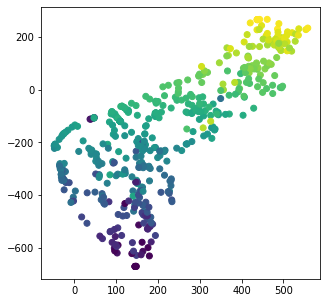

48.295268049560335


In [26]:
dCMD = np.load('dCMD.npy')
SortIndexs_cmd = np.argsort(dCMD,axis=1)
XYs_pred_cmd = np.zeros((N_tests,2))
for i in range(N_tests):
    K_Neig_cmd = XYs_train[SortIndexs_cmd[i,0:Knn],:]
    XYs_pred_cmd[i,:] = np.mean(K_Neig_cmd,axis=0)

x = XYs_pred_cmd[:,0]
y = XYs_pred_cmd[:,1]

plt.figure(figsize=(5,5))
plt.scatter(x,y,c=XYs_tests[:,1],cmap = 'viridis')
plt.savefig("CMD.pdf", dpi = 400, bbox_inches = 'tight', pad_inches = 0)
plt.show()


Es = XYs_tests - XYs_pred_cmd
Es_cmd = np.sqrt(Es[:,0]*Es[:,0] + Es[:,1]*Es[:,1])
MLE_cmd = np.mean(Es_cmd)
print(MLE_cmd)
data_sorted_cmd = np.sort(Es_cmd)
p_cmd = 1. * np.arange(len(Es_cmd)) / (len(Es_cmd) - 1)


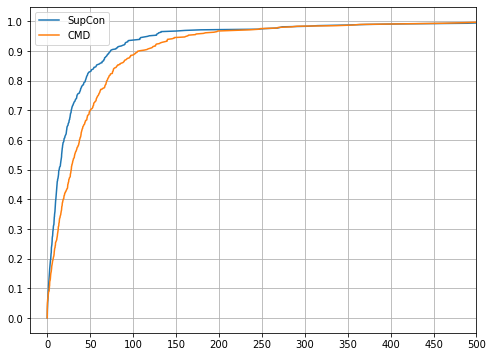

In [27]:
#===================================================================
plt.figure(figsize=(8,6))
plt.grid()
plt.plot(data_sorted_dis,p_dis,label='SupCon')
plt.plot(data_sorted_cmd,p_cmd,label='CMD')
plt.xlim((-20,400))
plt.xticks(np.arange(0,550,50))
plt.yticks(np.arange(0,1.05,0.1))
plt.legend()
plt.savefig("CDF.pdf", dpi = 400)
plt.show()